Imports

In [1]:
import time
from tqdm import tqdm
import math
import itertools
import numpy as np
import pandas as pd

import asyncio

import matplotlib.pyplot as plt
import seaborn as sns

from util import (
    calc_beta,
    simulation
)

Helpers

In [2]:
async def sim_wrap(seed, beta, z, p, params, pbar):
    '''Simulation method wrapper for asyncio compatibility.'''
    result = simulation(seed=seed, beta=beta, z=z, p=p, **params)
    pbar.update(1)
    return result

async def simulate_async(p, nsim, params, pbar):
    '''Run many train / test simulations asyncio-style.'''

    np.random.seed(0)

    z = np.ones(shape=p) / np.sqrt(p)
    beta = calc_beta(eta=np.random.normal(loc=1, scale=1, size=p))

    return await asyncio.gather(*[sim_wrap(seed=seed, beta=beta, z=z, p=p, params=params, pbar=pbar) for seed in range(1, nsim+1)])

def plot_data(df, figsize=(14, 3)):
    '''Plot resulting data to analyze how returns and volatilities behave.'''
    
    ncol = 2
    nrow = math.ceil(len(df.columns)/ncol)
    figure, axes = plt.subplots(nrow, ncol, figsize=figsize, sharex=False, sharey=True)

    for i, (ax, col) in enumerate(itertools.zip_longest(axes.flat, df.columns)):
        if ax is not None:
            color = 'blue' if i % 2 == 0 else 'orange'
            mu, sd = np.mean(df[col]), np.std(df[col])
            label = col + f' (MEAN: {round(mu, 4)}, SD: {round(sd, 4)}) '
        
            sns.lineplot(x=df.index, y=col, data=df, ax=ax, label=label, c=color)
            
            ax.axhline(y=mu, color='red', linestyle='--')
            ax.axhline(y=mu+sd, color='green', linestyle='--')
            ax.axhline(y=mu-sd, color='green', linestyle='--')

            ax.set_ylabel(f'Annualized value')
        
        else:
            figure.delaxes(ax)

    plt.tight_layout()
    plt.show()

Simulation

In [3]:
start = time.time()
p = 3000
nsim = 300

params = {
    'sigma': .16, 'delta': .50, 
    'n1': 12, 'f1': 12, 'n2': 3, 'f2': 12
}

pbar = tqdm(total=nsim, leave=False)
returns, volatilities = zip(*await simulate_async(p=p, nsim=nsim, params=params, pbar=pbar))
returns, volatilities = pd.DataFrame(returns), None
pbar.close()

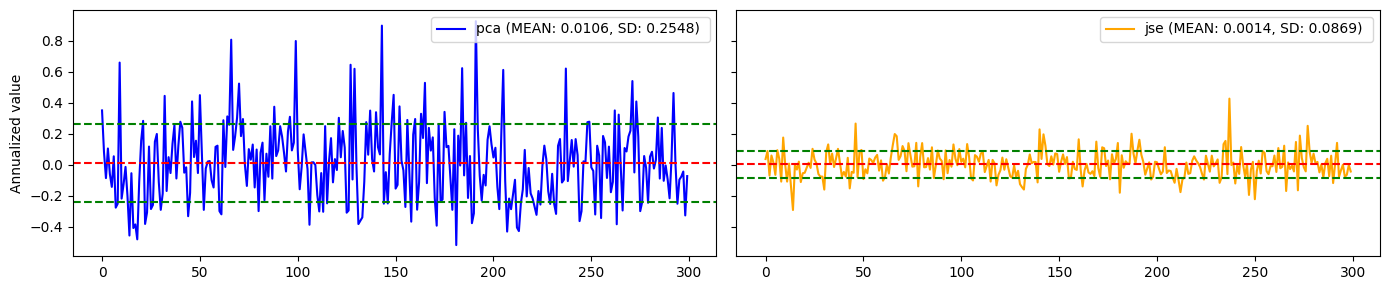

In [4]:
plot_data(df=returns)